# Model Performance Test


In [1]:
from dtsp.dataset import walk_forward_split, Seq2SeqDataSet, SimpleSeq2SeqDataSet, SimpleWaveNetDataSet
from dtsp.models import Seq2Seq, SimpleSeq2Seq, SimpleWaveNet
from torch.utils.data import DataLoader
from torch.utils.data import Subset, DataLoader
import torch
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from pathlib import Path
import shutil
import seaborn as sns

%matplotlib inline

def plot_attentions(attns):
    if attns.ndim == 4:
        assert attns.shape[0] == 1
        attns = attns.squeeze(0)
    if isinstance(attns, torch.Tensor):
        attns = attns.detach().numpy()
    n_head = attns.shape[1]
    
    base_size = 12
    
    hight = attns.shape[0]
    wide = attns.shape[2]
    for i in range(n_head):
        plt.figure(figsize=(16, hight / wide * 16))
        sns.heatmap(attns[:, i, :])
        plt.title(f"Attention {i}")
        plt.xlabel('history')
        plt.ylabel('prediction')


def plot_prediction(enc, y_pred, y_true):
    f = plt.figure(figsize=(12, 4))
    enc_lens = len(enc)
    dec_lens = len(y_pred)
    plt.plot(enc)
    plt.plot(range(enc_lens, enc_lens+dec_lens), y_pred, label='prediction', linestyle='--')
    plt.plot(range(enc_lens, enc_lens+dec_lens), y_true, label='true')
    plt.legend()

In [2]:
torch.__version__

'1.3.0'

## 1. prepare dataset

In [3]:
df = pd.read_csv('./data.csv', index_col='date_time', parse_dates=['date_time'])
series = df.values
month = df.index.month.values
df.head()

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,col_10,col_11,col_12,col_13,col_14,col_15,col_16,col_17,col_18,col_19
date_time,,,,,,,,,,,,,,,,,,,,
1998-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0,0.0,0
1998-02-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0,0.0,0
1998-03-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0,0.0,0
1998-04-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0,0.0,0
1998-05-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0,0.0,0


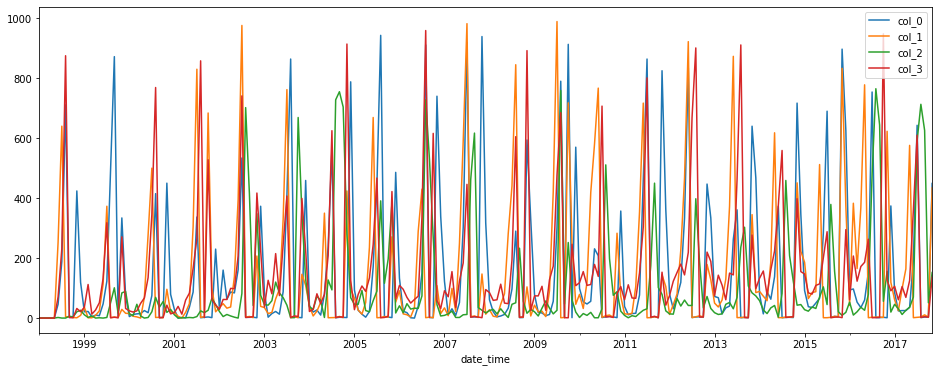

In [4]:
df.iloc[:, :4].plot(figsize=(16, 6))

**Target**

In [5]:
n_test = 12
n_val = 12
enc_lens = 72
dec_lens = 12
batch_size = 8
epochs = 100

## 1. Simple Seq2Seq Model

In [6]:
dataset = SimpleSeq2SeqDataSet(series, enc_lens, dec_lens)
idxes = list(range(len(dataset)))
train_idxes, _idxes = walk_forward_split(idxes, enc_lens, dec_lens, test_size=n_test + n_val)
valid_idxes, test_idxes = walk_forward_split(_idxes, enc_lens, dec_lens, test_size=n_test)

trn_set = Subset(dataset, train_idxes)
val_set = Subset(dataset, valid_idxes)
test_set = Subset(dataset, test_idxes)
trn_ld = DataLoader(trn_set, batch_size=batch_size, shuffle=True, drop_last=False)
val_ld = DataLoader(val_set, batch_size=batch_size, shuffle=False, drop_last=False)
test_ld = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [7]:
hp = {
        'path': Path('.').resolve() / 'logs',
        'target_size': 20,
        'rnn_type': 'LSTM',
        'dropout': 0.2,
        'hidden_size': 72,
        'teacher_forcing_rate': 0.5,
        'learning_rate': 0.001,
        'use_move_scale': True,
    }

compile_params = {
    'loss_fn': 'MSELoss',
    'optimizer': 'Adam',
    'lr_scheduler': 'CosineAnnealingWarmRestarts',
    'lr_scheduler_kw': {'T_0': 5, 'T_mult': 10},
    'metric': 'RMSE',
}

model = SimpleSeq2Seq(hp)
model.compile(**compile_params)
model.fit(epochs, trn_ld, val_ld, early_stopping=10, save_every_n_epochs=None, save_best_model=True)

batch 17 / 17, loss 0.979: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 16.83it/s]


epoch 1 / 100: train loss 1.023 val loss 1.162 RMSE 179.138
create model path: C:\Users\evilp\project\Deep-Time-Series-Prediction\notebooks\logs


batch 17 / 17, loss 0.981: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 16.37it/s]


epoch 2 / 100: train loss 0.892 val loss 0.983 RMSE 169.246


batch 17 / 17, loss 0.876: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 17.18it/s]


epoch 3 / 100: train loss 0.806 val loss 0.958 RMSE 165.882


batch 17 / 17, loss 0.706: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 18.83it/s]


epoch 4 / 100: train loss 0.772 val loss 0.945 RMSE 165.125


batch 17 / 17, loss 0.518: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 18.21it/s]


epoch 5 / 100: train loss 0.754 val loss 0.944 RMSE 164.906


batch 17 / 17, loss 0.710: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 18.47it/s]


epoch 6 / 100: train loss 0.750 val loss 0.910 RMSE 161.093


batch 17 / 17, loss 0.734: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 17.57it/s]


epoch 7 / 100: train loss 0.733 val loss 0.871 RMSE 156.513


batch 17 / 17, loss 0.548: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 17.63it/s]


epoch 8 / 100: train loss 0.720 val loss 1.018 RMSE 171.194


batch 17 / 17, loss 0.750: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 19.28it/s]


epoch 9 / 100: train loss 0.725 val loss 0.889 RMSE 156.724


batch 17 / 17, loss 0.641: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 18.57it/s]


epoch 10 / 100: train loss 0.666 val loss 0.839 RMSE 153.901


batch 17 / 17, loss 0.549: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 18.94it/s]


epoch 11 / 100: train loss 0.624 val loss 0.815 RMSE 150.946


batch 17 / 17, loss 0.609: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 17.55it/s]


epoch 12 / 100: train loss 0.635 val loss 0.798 RMSE 149.025


batch 17 / 17, loss 0.505: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 18.53it/s]


epoch 13 / 100: train loss 0.611 val loss 0.785 RMSE 147.334


batch 17 / 17, loss 0.634: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 17.32it/s]


epoch 14 / 100: train loss 0.605 val loss 0.784 RMSE 147.119


batch 17 / 17, loss 0.475: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 18.57it/s]


epoch 15 / 100: train loss 0.576 val loss 0.767 RMSE 145.744


batch 17 / 17, loss 0.701: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 16.76it/s]


epoch 16 / 100: train loss 0.611 val loss 0.768 RMSE 145.913


batch 17 / 17, loss 0.508: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.10it/s]


epoch 17 / 100: train loss 0.577 val loss 0.781 RMSE 147.572


batch 17 / 17, loss 0.565: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 13.78it/s]


epoch 18 / 100: train loss 0.545 val loss 0.756 RMSE 144.348


batch 17 / 17, loss 0.586: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 14.34it/s]


epoch 19 / 100: train loss 0.558 val loss 0.753 RMSE 144.688


batch 17 / 17, loss 0.439: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 13.35it/s]


epoch 20 / 100: train loss 0.538 val loss 0.754 RMSE 145.325


batch 17 / 17, loss 0.448: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 14.49it/s]


epoch 21 / 100: train loss 0.549 val loss 0.738 RMSE 142.142


batch 17 / 17, loss 0.609: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 14.43it/s]


epoch 22 / 100: train loss 0.524 val loss 0.739 RMSE 142.669


batch 17 / 17, loss 0.486: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 12.99it/s]


epoch 23 / 100: train loss 0.523 val loss 0.731 RMSE 142.139


batch 17 / 17, loss 0.448: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 14.78it/s]


epoch 24 / 100: train loss 0.532 val loss 0.721 RMSE 140.464


batch 17 / 17, loss 0.451: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 13.95it/s]


epoch 25 / 100: train loss 0.520 val loss 0.714 RMSE 141.417


batch 17 / 17, loss 0.535: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 18.50it/s]


epoch 26 / 100: train loss 0.502 val loss 0.712 RMSE 140.819


batch 17 / 17, loss 0.562: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 17.39it/s]


epoch 27 / 100: train loss 0.504 val loss 0.733 RMSE 143.100


batch 17 / 17, loss 0.420: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 17.37it/s]


epoch 28 / 100: train loss 0.502 val loss 0.712 RMSE 139.620


batch 17 / 17, loss 0.485: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 17.02it/s]


epoch 29 / 100: train loss 0.486 val loss 0.692 RMSE 138.444


batch 17 / 17, loss 0.461: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 16.87it/s]


epoch 30 / 100: train loss 0.485 val loss 0.691 RMSE 137.922


batch 17 / 17, loss 0.578: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 16.33it/s]


epoch 31 / 100: train loss 0.496 val loss 0.688 RMSE 138.116


batch 17 / 17, loss 0.351: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 18.23it/s]


epoch 32 / 100: train loss 0.469 val loss 0.673 RMSE 136.343


batch 17 / 17, loss 0.356: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 17.64it/s]


epoch 33 / 100: train loss 0.470 val loss 0.686 RMSE 137.145


batch 17 / 17, loss 0.403: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 17.16it/s]


epoch 34 / 100: train loss 0.475 val loss 0.671 RMSE 136.378


batch 17 / 17, loss 0.475: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 19.38it/s]


epoch 35 / 100: train loss 0.442 val loss 0.679 RMSE 137.747


batch 17 / 17, loss 0.393: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 18.84it/s]


epoch 36 / 100: train loss 0.444 val loss 0.675 RMSE 137.263


batch 17 / 17, loss 0.381: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 16.55it/s]


epoch 37 / 100: train loss 0.458 val loss 0.666 RMSE 135.852


batch 17 / 17, loss 0.388: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 17.28it/s]


epoch 38 / 100: train loss 0.454 val loss 0.667 RMSE 135.829


batch 17 / 17, loss 0.404: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 18.98it/s]


epoch 39 / 100: train loss 0.430 val loss 0.659 RMSE 135.002


batch 17 / 17, loss 0.369: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 18.31it/s]


epoch 40 / 100: train loss 0.439 val loss 0.657 RMSE 134.733


batch 17 / 17, loss 0.339: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 19.20it/s]


epoch 41 / 100: train loss 0.418 val loss 0.659 RMSE 134.899


batch 17 / 17, loss 0.414: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 18.60it/s]


epoch 42 / 100: train loss 0.426 val loss 0.654 RMSE 134.385


batch 17 / 17, loss 0.372: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 17.48it/s]


epoch 43 / 100: train loss 0.439 val loss 0.652 RMSE 133.789


batch 17 / 17, loss 0.497: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 17.71it/s]


epoch 44 / 100: train loss 0.442 val loss 0.652 RMSE 133.734


batch 17 / 17, loss 0.390: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 18.25it/s]


epoch 45 / 100: train loss 0.428 val loss 0.647 RMSE 133.377


batch 17 / 17, loss 0.495: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 16.54it/s]


epoch 46 / 100: train loss 0.452 val loss 0.648 RMSE 133.721


batch 17 / 17, loss 0.382: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 18.09it/s]


epoch 47 / 100: train loss 0.423 val loss 0.647 RMSE 133.495


batch 17 / 17, loss 0.327: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 17.20it/s]


epoch 48 / 100: train loss 0.432 val loss 0.649 RMSE 133.715


batch 17 / 17, loss 0.373: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 16.58it/s]


epoch 49 / 100: train loss 0.450 val loss 0.648 RMSE 133.435


batch 17 / 17, loss 0.418: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 16.95it/s]


epoch 50 / 100: train loss 0.440 val loss 0.646 RMSE 133.173


batch 17 / 17, loss 0.387: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 16.56it/s]


epoch 51 / 100: train loss 0.434 val loss 0.646 RMSE 133.306


batch 17 / 17, loss 0.372: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 16.66it/s]


epoch 52 / 100: train loss 0.440 val loss 0.645 RMSE 133.210


batch 17 / 17, loss 0.340: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 18.41it/s]


epoch 53 / 100: train loss 0.426 val loss 0.645 RMSE 133.205


batch 17 / 17, loss 0.349: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 18.41it/s]


epoch 54 / 100: train loss 0.416 val loss 0.645 RMSE 133.216


batch 17 / 17, loss 0.500: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 17.47it/s]


epoch 55 / 100: train loss 0.426 val loss 0.645 RMSE 133.215


batch 17 / 17, loss 0.540: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 15.48it/s]


epoch 56 / 100: train loss 0.456 val loss 0.681 RMSE 137.522


batch 17 / 17, loss 0.525: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 16.53it/s]


epoch 57 / 100: train loss 0.457 val loss 0.670 RMSE 136.121


batch 17 / 17, loss 0.582: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 16.07it/s]


epoch 58 / 100: train loss 0.511 val loss 0.731 RMSE 144.368


batch 17 / 17, loss 0.337: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 17.34it/s]


epoch 59 / 100: train loss 0.431 val loss 0.633 RMSE 131.650


batch 17 / 17, loss 0.326: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 18.84it/s]


epoch 60 / 100: train loss 0.409 val loss 0.663 RMSE 135.024


batch 17 / 17, loss 0.340: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 17.28it/s]


epoch 61 / 100: train loss 0.419 val loss 0.695 RMSE 137.739


batch 17 / 17, loss 0.331: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 17.30it/s]


epoch 62 / 100: train loss 0.405 val loss 0.631 RMSE 130.291


batch 17 / 17, loss 0.388: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 15.76it/s]


epoch 63 / 100: train loss 0.405 val loss 0.606 RMSE 128.374


batch 17 / 17, loss 0.290: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 16.66it/s]


epoch 64 / 100: train loss 0.404 val loss 0.646 RMSE 132.794


batch 17 / 17, loss 0.414: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 16.69it/s]


epoch 65 / 100: train loss 0.412 val loss 0.595 RMSE 126.946


batch 17 / 17, loss 0.285: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 17.98it/s]


epoch 66 / 100: train loss 0.395 val loss 0.628 RMSE 131.716


batch 17 / 17, loss 0.672: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 16.68it/s]


epoch 67 / 100: train loss 0.420 val loss 0.582 RMSE 123.581


batch 17 / 17, loss 0.311: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 17.10it/s]


epoch 68 / 100: train loss 0.386 val loss 0.652 RMSE 133.576


batch 17 / 17, loss 0.434: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 16.52it/s]


epoch 69 / 100: train loss 0.391 val loss 0.634 RMSE 130.919


batch 17 / 17, loss 0.298: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 15.84it/s]


epoch 70 / 100: train loss 0.390 val loss 0.562 RMSE 121.630


batch 17 / 17, loss 0.268: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 18.55it/s]


epoch 71 / 100: train loss 0.337 val loss 0.552 RMSE 120.390


batch 17 / 17, loss 0.385: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 17.01it/s]


epoch 72 / 100: train loss 0.343 val loss 0.544 RMSE 119.119


batch 17 / 17, loss 0.324: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 17.40it/s]


epoch 73 / 100: train loss 0.331 val loss 0.548 RMSE 120.311


batch 17 / 17, loss 0.373: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 17.54it/s]


epoch 74 / 100: train loss 0.319 val loss 0.538 RMSE 116.860


batch 17 / 17, loss 0.315: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 17.54it/s]


epoch 75 / 100: train loss 0.310 val loss 0.523 RMSE 115.271


batch 17 / 17, loss 0.334: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 18.71it/s]


epoch 76 / 100: train loss 0.292 val loss 0.519 RMSE 114.769


batch 17 / 17, loss 0.261: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 17.41it/s]


epoch 77 / 100: train loss 0.307 val loss 0.512 RMSE 112.886


batch 17 / 17, loss 0.257: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 19.68it/s]


epoch 78 / 100: train loss 0.277 val loss 0.520 RMSE 114.319


batch 17 / 17, loss 0.238: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 19.66it/s]


epoch 79 / 100: train loss 0.279 val loss 0.517 RMSE 114.495


batch 17 / 17, loss 0.233: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 17.34it/s]


epoch 80 / 100: train loss 0.302 val loss 0.562 RMSE 120.326


batch 17 / 17, loss 0.316: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 16.30it/s]


epoch 81 / 100: train loss 0.297 val loss 0.498 RMSE 110.857


batch 17 / 17, loss 0.200: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 18.21it/s]


epoch 82 / 100: train loss 0.265 val loss 0.483 RMSE 109.198


batch 17 / 17, loss 0.279: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 16.80it/s]


epoch 83 / 100: train loss 0.277 val loss 0.480 RMSE 107.171


batch 17 / 17, loss 0.294: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 17.42it/s]


epoch 84 / 100: train loss 0.266 val loss 0.484 RMSE 107.949


batch 17 / 17, loss 0.276: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 18.01it/s]


epoch 85 / 100: train loss 0.258 val loss 0.486 RMSE 108.485


batch 17 / 17, loss 0.293: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 18.90it/s]


epoch 86 / 100: train loss 0.250 val loss 0.472 RMSE 105.408


batch 17 / 17, loss 0.222: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 16.45it/s]


epoch 87 / 100: train loss 0.256 val loss 0.478 RMSE 104.480


batch 17 / 17, loss 0.263: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 17.57it/s]


epoch 88 / 100: train loss 0.246 val loss 0.459 RMSE 103.850


batch 17 / 17, loss 0.190: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 17.20it/s]


epoch 89 / 100: train loss 0.240 val loss 0.443 RMSE 101.595


batch 17 / 17, loss 0.215: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 18.00it/s]


epoch 90 / 100: train loss 0.230 val loss 0.441 RMSE 99.918


batch 17 / 17, loss 0.231: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 17.25it/s]


epoch 91 / 100: train loss 0.232 val loss 0.428 RMSE 98.084


batch 17 / 17, loss 0.246: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 17.48it/s]


epoch 92 / 100: train loss 0.225 val loss 0.445 RMSE 99.054


batch 17 / 17, loss 0.191: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 18.43it/s]


epoch 93 / 100: train loss 0.210 val loss 0.420 RMSE 95.531


batch 17 / 17, loss 0.225: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 18.16it/s]


epoch 94 / 100: train loss 0.212 val loss 0.427 RMSE 96.602


batch 17 / 17, loss 0.205: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 18.86it/s]


epoch 95 / 100: train loss 0.196 val loss 0.427 RMSE 96.316


batch 17 / 17, loss 0.151: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 18.98it/s]


epoch 96 / 100: train loss 0.195 val loss 0.426 RMSE 95.827


batch 17 / 17, loss 0.299: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 16.25it/s]


epoch 97 / 100: train loss 0.214 val loss 0.404 RMSE 91.912


batch 17 / 17, loss 0.162: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 16.74it/s]


epoch 98 / 100: train loss 0.208 val loss 0.411 RMSE 93.712


batch 17 / 17, loss 0.170: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 18.94it/s]


epoch 99 / 100: train loss 0.199 val loss 0.402 RMSE 91.809


batch 17 / 17, loss 0.365: 100%|███████████████████████████████████████████████████████| 17/17 [00:00<00:00, 18.21it/s]


epoch 100 / 100: train loss 0.236 val loss 0.547 RMSE 114.538
best model save in C:\Users\evilp\project\Deep-Time-Series-Prediction\notebooks\logs\SimpleSeq2Seq_epoch_99_0.402.pkl


In [12]:
model.reload(model.best_model_path())
print(' - ' * 20)
print(f'train loss: {model.eval_cycle(trn_ld)[0]:.3f}, '
      f'valid loss: {model.eval_cycle(val_ld)[0]:.3f}, '
      f'test loss :{model.eval_cycle(test_ld)[0]:.3f}, '
      f'test RMSE :{model.eval_cycle(test_ld)[1]:.3f}, ')
shutil.rmtree(hp['path'])

 -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 
train loss: 0.171, valid loss: 0.402, test loss :0.514, test RMSE :106.592, 


FileNotFoundError: [WinError 3] 系统找不到指定的路径。: 'C:\\Users\\evilp\\project\\Deep-Time-Series-Prediction\\notebooks\\logs'

Text(0.5, 1.0, 'Simple Seq2Seq prediction')

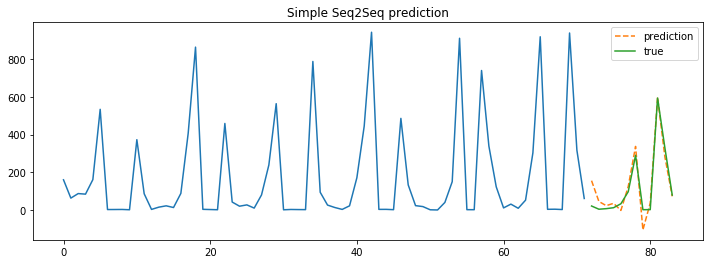

In [13]:
k = 0
h = 0

enc_seqs = val_set[k]['enc_inputs']
enc_inputs = torch.tensor(enc_seqs).unsqueeze(0)
dec_outputs = val_set[k]['dec_outputs']
dec_step = dec_outputs.shape[0]
pred = model.predict(enc_inputs, dec_step, use_move_scale=True).squeeze().detach().numpy()
plot_prediction(enc_seqs[:, h], pred[:, h], dec_outputs[:, h])
plt.title('Simple Seq2Seq prediction')

## 2. Seq2Seq(Attention 0)

In [10]:
dataset = Seq2SeqDataSet(series, enc_lens, dec_lens, categorical_var=month)
idxes = list(range(len(dataset)))
train_idxes, _idxes = walk_forward_split(idxes, enc_lens, dec_lens, test_size=n_test + n_val)
valid_idxes, test_idxes = walk_forward_split(_idxes, enc_lens, dec_lens, test_size=n_test)

trn_set = Subset(dataset, train_idxes)
val_set = Subset(dataset, valid_idxes)
test_set = Subset(dataset, test_idxes)
trn_ld = DataLoader(trn_set, batch_size=batch_size, shuffle=True, drop_last=False)
val_ld = DataLoader(val_set, batch_size=batch_size, shuffle=False, drop_last=False)
test_ld = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [11]:
hp = {
        'path': Path('.').resolve() / 'logs',
        'target_size': 20,
        'rnn_type': 'LSTM',
        'dropout': 0.1,
        'hidden_size': 128,
        'teacher_forcing_rate': 0.5,
        'n_head': 4,
        'use_attn': False,
        'trans_hidden_size': 4,
        'trans_continuous_var': None,
        'trans_category_var': [(13, 2)],
        'trans_bidirectional': True,
        'trans_rnn_type': 'LSTM',
        'use_move_scale': True,
    }

compile_params = {
    'loss_fn': 'MSELoss',
    'optimizer': 'Adam',
    'lr': 0.001,
    'lr_scheduler': 'CosineAnnealingWarmRestarts',
    'lr_scheduler_kw': {'T_0': 5, 'T_mult': 10},
    'metric': 'RMSE',
}

model = Seq2Seq(hp)
model.compile(**compile_params)
model.fit(epochs, trn_ld, val_ld, early_stopping=10, save_every_n_epochs=None, save_best_model=True)

batch 17 / 17, loss 0.730: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.77it/s]


epoch 1 / 100: train loss 0.971 val loss 0.924 RMSE 163.423
create model path: C:\Users\evilp\project\Deep-Time-Series-Prediction\notebooks\logs


batch 17 / 17, loss 0.639: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.91it/s]


epoch 2 / 100: train loss 0.753 val loss 0.840 RMSE 153.821


batch 17 / 17, loss 0.565: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.04it/s]


epoch 3 / 100: train loss 0.677 val loss 0.812 RMSE 150.486


batch 17 / 17, loss 0.649: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.95it/s]


epoch 4 / 100: train loss 0.656 val loss 0.806 RMSE 150.023


batch 17 / 17, loss 0.522: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.90it/s]


epoch 5 / 100: train loss 0.642 val loss 0.803 RMSE 149.715


batch 17 / 17, loss 0.578: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.95it/s]


epoch 6 / 100: train loss 0.626 val loss 0.777 RMSE 146.279


batch 17 / 17, loss 1.011: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.90it/s]


epoch 7 / 100: train loss 0.622 val loss 0.781 RMSE 145.849


batch 17 / 17, loss 0.546: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.03it/s]


epoch 8 / 100: train loss 0.584 val loss 0.769 RMSE 145.987


batch 17 / 17, loss 0.668: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.01it/s]


epoch 9 / 100: train loss 0.556 val loss 0.728 RMSE 141.434


batch 17 / 17, loss 0.491: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.95it/s]


epoch 10 / 100: train loss 0.530 val loss 0.724 RMSE 141.266


batch 17 / 17, loss 0.382: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.74it/s]


epoch 11 / 100: train loss 0.513 val loss 0.721 RMSE 140.775


batch 17 / 17, loss 0.515: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.84it/s]


epoch 12 / 100: train loss 0.491 val loss 0.688 RMSE 136.860


batch 17 / 17, loss 0.545: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.10it/s]


epoch 13 / 100: train loss 0.436 val loss 0.669 RMSE 134.305


batch 17 / 17, loss 0.470: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.23it/s]


epoch 14 / 100: train loss 0.451 val loss 0.679 RMSE 135.957


batch 17 / 17, loss 0.479: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.04it/s]


epoch 15 / 100: train loss 0.430 val loss 0.669 RMSE 133.771


batch 17 / 17, loss 0.422: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.16it/s]


epoch 16 / 100: train loss 0.368 val loss 0.607 RMSE 127.032


batch 17 / 17, loss 0.323: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.06it/s]


epoch 17 / 100: train loss 0.357 val loss 0.653 RMSE 131.870


batch 17 / 17, loss 0.350: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.85it/s]


epoch 18 / 100: train loss 0.360 val loss 0.569 RMSE 121.395


batch 17 / 17, loss 0.307: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.09it/s]


epoch 19 / 100: train loss 0.332 val loss 0.551 RMSE 118.104


batch 17 / 17, loss 0.251: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.08it/s]


epoch 20 / 100: train loss 0.308 val loss 0.538 RMSE 116.554


batch 17 / 17, loss 0.231: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.89it/s]


epoch 21 / 100: train loss 0.282 val loss 0.527 RMSE 115.526


batch 17 / 17, loss 0.378: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.18it/s]


epoch 22 / 100: train loss 0.272 val loss 0.517 RMSE 113.294


batch 17 / 17, loss 0.240: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.13it/s]


epoch 23 / 100: train loss 0.268 val loss 0.555 RMSE 118.080


batch 17 / 17, loss 0.229: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.16it/s]


epoch 24 / 100: train loss 0.275 val loss 0.499 RMSE 110.983


batch 17 / 17, loss 0.198: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.13it/s]


epoch 25 / 100: train loss 0.254 val loss 0.499 RMSE 111.399


batch 17 / 17, loss 0.203: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.22it/s]


epoch 26 / 100: train loss 0.235 val loss 0.478 RMSE 107.298


batch 17 / 17, loss 0.132: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.15it/s]


epoch 27 / 100: train loss 0.218 val loss 0.453 RMSE 103.776


batch 17 / 17, loss 0.214: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.93it/s]


epoch 28 / 100: train loss 0.215 val loss 0.440 RMSE 101.222


batch 17 / 17, loss 0.160: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.02it/s]


epoch 29 / 100: train loss 0.203 val loss 0.424 RMSE 98.366


batch 17 / 17, loss 0.270: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.91it/s]


epoch 30 / 100: train loss 0.194 val loss 0.409 RMSE 95.432


batch 17 / 17, loss 0.243: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.97it/s]


epoch 31 / 100: train loss 0.180 val loss 0.398 RMSE 92.502


batch 17 / 17, loss 0.203: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.11it/s]


epoch 32 / 100: train loss 0.167 val loss 0.380 RMSE 90.983


batch 17 / 17, loss 0.161: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.80it/s]


epoch 33 / 100: train loss 0.171 val loss 0.370 RMSE 88.814


batch 17 / 17, loss 0.171: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.14it/s]


epoch 34 / 100: train loss 0.158 val loss 0.374 RMSE 89.683


batch 17 / 17, loss 0.135: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.04it/s]


epoch 35 / 100: train loss 0.153 val loss 0.362 RMSE 86.522


batch 17 / 17, loss 0.115: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.12it/s]


epoch 36 / 100: train loss 0.144 val loss 0.347 RMSE 83.927


batch 17 / 17, loss 0.120: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.01it/s]


epoch 37 / 100: train loss 0.143 val loss 0.340 RMSE 82.479


batch 17 / 17, loss 0.121: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.82it/s]


epoch 38 / 100: train loss 0.137 val loss 0.341 RMSE 81.917


batch 17 / 17, loss 0.119: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.09it/s]


epoch 39 / 100: train loss 0.130 val loss 0.338 RMSE 81.118


batch 17 / 17, loss 0.170: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.04it/s]


epoch 40 / 100: train loss 0.129 val loss 0.327 RMSE 79.910


batch 17 / 17, loss 0.144: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.72it/s]


epoch 41 / 100: train loss 0.130 val loss 0.327 RMSE 79.180


batch 17 / 17, loss 0.090: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.03it/s]


epoch 42 / 100: train loss 0.121 val loss 0.322 RMSE 78.181


batch 17 / 17, loss 0.131: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.01it/s]


epoch 43 / 100: train loss 0.122 val loss 0.318 RMSE 77.566


batch 17 / 17, loss 0.119: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.25it/s]


epoch 44 / 100: train loss 0.118 val loss 0.315 RMSE 77.080


batch 17 / 17, loss 0.114: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.07it/s]


epoch 45 / 100: train loss 0.118 val loss 0.316 RMSE 76.956


batch 17 / 17, loss 0.146: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.97it/s]


epoch 46 / 100: train loss 0.116 val loss 0.313 RMSE 76.239


batch 17 / 17, loss 0.087: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.92it/s]


epoch 47 / 100: train loss 0.115 val loss 0.313 RMSE 76.161


batch 17 / 17, loss 0.107: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.95it/s]


epoch 48 / 100: train loss 0.115 val loss 0.312 RMSE 75.968


batch 17 / 17, loss 0.121: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.11it/s]


epoch 49 / 100: train loss 0.112 val loss 0.311 RMSE 75.654


batch 17 / 17, loss 0.087: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.34it/s]


epoch 50 / 100: train loss 0.110 val loss 0.311 RMSE 75.585


batch 17 / 17, loss 0.101: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.10it/s]


epoch 51 / 100: train loss 0.115 val loss 0.310 RMSE 75.508


batch 17 / 17, loss 0.093: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.08it/s]


epoch 52 / 100: train loss 0.111 val loss 0.310 RMSE 75.416


batch 17 / 17, loss 0.096: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.16it/s]


epoch 53 / 100: train loss 0.112 val loss 0.310 RMSE 75.412


batch 17 / 17, loss 0.091: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.96it/s]


epoch 54 / 100: train loss 0.112 val loss 0.310 RMSE 75.403


batch 17 / 17, loss 0.086: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.20it/s]


epoch 55 / 100: train loss 0.113 val loss 0.310 RMSE 75.402


batch 17 / 17, loss 0.131: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.04it/s]


epoch 56 / 100: train loss 0.110 val loss 0.310 RMSE 76.421


batch 17 / 17, loss 0.118: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.91it/s]


epoch 57 / 100: train loss 0.118 val loss 0.347 RMSE 84.904


batch 17 / 17, loss 0.125: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.13it/s]


epoch 58 / 100: train loss 0.160 val loss 0.405 RMSE 95.085


batch 17 / 17, loss 0.122: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.06it/s]


epoch 59 / 100: train loss 0.147 val loss 0.368 RMSE 83.730


batch 17 / 17, loss 0.095: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.29it/s]


epoch 60 / 100: train loss 0.109 val loss 0.344 RMSE 82.780


batch 17 / 17, loss 0.078: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.97it/s]


epoch 61 / 100: train loss 0.108 val loss 0.289 RMSE 70.283


batch 17 / 17, loss 0.075: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.39it/s]


epoch 62 / 100: train loss 0.087 val loss 0.278 RMSE 66.237


batch 17 / 17, loss 0.064: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.01it/s]


epoch 63 / 100: train loss 0.077 val loss 0.279 RMSE 64.653


batch 17 / 17, loss 0.063: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.30it/s]


epoch 64 / 100: train loss 0.075 val loss 0.274 RMSE 64.739


batch 17 / 17, loss 0.079: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.10it/s]


epoch 65 / 100: train loss 0.073 val loss 0.262 RMSE 60.532


batch 17 / 17, loss 0.052: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.03it/s]


epoch 66 / 100: train loss 0.066 val loss 0.255 RMSE 59.334


batch 17 / 17, loss 0.064: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.13it/s]


epoch 67 / 100: train loss 0.060 val loss 0.248 RMSE 56.812


batch 17 / 17, loss 0.044: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.04it/s]


epoch 68 / 100: train loss 0.057 val loss 0.247 RMSE 56.051


batch 17 / 17, loss 0.066: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.36it/s]


epoch 69 / 100: train loss 0.052 val loss 0.245 RMSE 54.568


batch 17 / 17, loss 0.048: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.06it/s]


epoch 70 / 100: train loss 0.053 val loss 0.237 RMSE 53.757


batch 17 / 17, loss 0.059: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.00it/s]


epoch 71 / 100: train loss 0.050 val loss 0.237 RMSE 53.241


batch 17 / 17, loss 0.041: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.08it/s]


epoch 72 / 100: train loss 0.047 val loss 0.240 RMSE 54.696


batch 17 / 17, loss 0.048: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.76it/s]


epoch 73 / 100: train loss 0.049 val loss 0.240 RMSE 52.267


batch 17 / 17, loss 0.050: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.92it/s]


epoch 74 / 100: train loss 0.047 val loss 0.234 RMSE 51.286


batch 17 / 17, loss 0.036: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.04it/s]


epoch 75 / 100: train loss 0.043 val loss 0.235 RMSE 51.161


batch 17 / 17, loss 0.043: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.16it/s]


epoch 76 / 100: train loss 0.041 val loss 0.228 RMSE 50.025


batch 17 / 17, loss 0.037: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.32it/s]


epoch 77 / 100: train loss 0.039 val loss 0.225 RMSE 48.901


batch 17 / 17, loss 0.035: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.23it/s]


epoch 78 / 100: train loss 0.038 val loss 0.227 RMSE 49.149


batch 17 / 17, loss 0.036: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.10it/s]


epoch 79 / 100: train loss 0.037 val loss 0.224 RMSE 48.646


batch 17 / 17, loss 0.031: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.11it/s]


epoch 80 / 100: train loss 0.036 val loss 0.226 RMSE 48.415


batch 17 / 17, loss 0.033: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.09it/s]


epoch 81 / 100: train loss 0.035 val loss 0.229 RMSE 49.324


batch 17 / 17, loss 0.033: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.07it/s]


epoch 82 / 100: train loss 0.035 val loss 0.226 RMSE 47.356


batch 17 / 17, loss 0.037: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.85it/s]


epoch 83 / 100: train loss 0.034 val loss 0.224 RMSE 47.920


batch 17 / 17, loss 0.030: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.85it/s]


epoch 84 / 100: train loss 0.033 val loss 0.219 RMSE 46.837


batch 17 / 17, loss 0.035: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.27it/s]


epoch 85 / 100: train loss 0.031 val loss 0.222 RMSE 46.171


batch 17 / 17, loss 0.032: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.10it/s]


epoch 86 / 100: train loss 0.031 val loss 0.220 RMSE 45.963


batch 17 / 17, loss 0.031: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.14it/s]


epoch 87 / 100: train loss 0.030 val loss 0.216 RMSE 45.638


batch 17 / 17, loss 0.029: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.00it/s]


epoch 88 / 100: train loss 0.030 val loss 0.217 RMSE 45.491


batch 17 / 17, loss 0.025: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.16it/s]


epoch 89 / 100: train loss 0.029 val loss 0.213 RMSE 44.617


batch 17 / 17, loss 0.032: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.32it/s]


epoch 90 / 100: train loss 0.028 val loss 0.213 RMSE 44.792


batch 17 / 17, loss 0.026: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.16it/s]


epoch 91 / 100: train loss 0.028 val loss 0.208 RMSE 43.367


batch 17 / 17, loss 0.025: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.41it/s]


epoch 92 / 100: train loss 0.027 val loss 0.213 RMSE 43.497


batch 17 / 17, loss 0.025: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.97it/s]


epoch 93 / 100: train loss 0.026 val loss 0.206 RMSE 42.721


batch 17 / 17, loss 0.026: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.18it/s]


epoch 94 / 100: train loss 0.025 val loss 0.208 RMSE 42.644


batch 17 / 17, loss 0.024: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.96it/s]


epoch 95 / 100: train loss 0.025 val loss 0.206 RMSE 43.289


batch 17 / 17, loss 0.021: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.80it/s]


epoch 96 / 100: train loss 0.025 val loss 0.203 RMSE 41.775


batch 17 / 17, loss 0.028: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.09it/s]


epoch 97 / 100: train loss 0.024 val loss 0.208 RMSE 41.952


batch 17 / 17, loss 0.026: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.91it/s]


epoch 98 / 100: train loss 0.025 val loss 0.209 RMSE 43.165


batch 17 / 17, loss 0.018: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.09it/s]


epoch 99 / 100: train loss 0.024 val loss 0.205 RMSE 42.098


batch 17 / 17, loss 0.022: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.04it/s]


epoch 100 / 100: train loss 0.024 val loss 0.200 RMSE 41.728
best model save in C:\Users\evilp\project\Deep-Time-Series-Prediction\notebooks\logs\Seq2Seq_epoch_100_0.200.pkl


In [12]:
model.reload(model.best_model_path())
print(' - ' * 20)
print(f'train loss: {model.eval_cycle(trn_ld)[0]:.3f}, '
      f'valid loss: {model.eval_cycle(val_ld)[0]:.3f}, '
      f'test loss :{model.eval_cycle(test_ld)[0]:.3f}, '
      f'test RMSE :{model.eval_cycle(test_ld)[1]:.3f}, ')
shutil.rmtree(hp['path'])

 -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 
train loss: 0.011, valid loss: 0.200, test loss :0.360, test RMSE :65.627, 


Text(0.5, 1.0, 'Seq2Seq 0 Attention prediction')

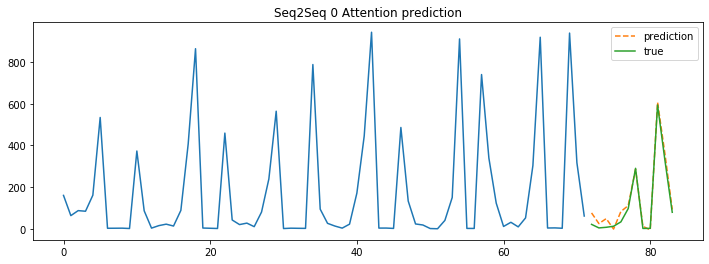

In [13]:
k = 0
h = 0

enc_seqs = val_set[k]['enc_inputs']
enc_inputs = torch.tensor(enc_seqs).unsqueeze(0)
category_x = torch.tensor(val_set[k]['category_x']).unsqueeze(0)
dec_outputs = val_set[k]['dec_outputs']
dec_step = dec_outputs.shape[0]
pred = model.predict(enc_inputs, dec_step, category_x=category_x, use_move_scale=True).squeeze().detach().numpy()
plot_prediction(enc_seqs[:, h], pred[:, h], dec_outputs[:, h])
plt.title('Seq2Seq 0 Attention prediction')

## 3. Seq2Seq(Attention 1)

In [14]:
hp = {
        'path': Path('.').resolve() / 'logs',
        'target_size': 20,
        'rnn_type': 'LSTM',
        'dropout': 0.1,
        'hidden_size': 128,
        'teacher_forcing_rate': 0.5,
        'n_head': 1,
        'use_attn': True,
        'trans_hidden_size': 4,
        'trans_continuous_var': None,
        'trans_category_var': [(13, 2)],
        'trans_bidirectional': True,
        'trans_rnn_type': 'LSTM',
        'use_move_scale': True,
    }

compile_params = {
    'loss_fn': 'MSELoss',
    'optimizer': 'Adam',
    'lr': 0.001,
    'lr_scheduler': 'CosineAnnealingWarmRestarts',
    'lr_scheduler_kw': {'T_0': 5, 'T_mult': 10},
    'metric': 'RMSE',
}

model = Seq2Seq(hp)
model.compile(**compile_params)
model.fit(epochs, trn_ld, val_ld, early_stopping=10, save_every_n_epochs=None, save_best_model=True)

batch 17 / 17, loss 0.669: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.29it/s]


epoch 1 / 100: train loss 0.953 val loss 0.956 RMSE 165.063
create model path: C:\Users\evilp\project\Deep-Time-Series-Prediction\notebooks\logs


batch 17 / 17, loss 0.614: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.67it/s]


epoch 2 / 100: train loss 0.796 val loss 0.937 RMSE 162.343


batch 17 / 17, loss 0.643: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.82it/s]


epoch 3 / 100: train loss 0.732 val loss 0.860 RMSE 155.053


batch 17 / 17, loss 0.619: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.82it/s]


epoch 4 / 100: train loss 0.684 val loss 0.831 RMSE 152.771


batch 17 / 17, loss 0.557: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.00it/s]


epoch 5 / 100: train loss 0.673 val loss 0.830 RMSE 152.612


batch 17 / 17, loss 0.689: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.78it/s]


epoch 6 / 100: train loss 0.674 val loss 0.801 RMSE 149.389


batch 17 / 17, loss 0.665: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.83it/s]


epoch 7 / 100: train loss 0.650 val loss 0.799 RMSE 148.491


batch 17 / 17, loss 0.980: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.24it/s]


epoch 8 / 100: train loss 0.606 val loss 0.758 RMSE 144.278


batch 17 / 17, loss 0.513: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.31it/s]


epoch 9 / 100: train loss 0.568 val loss 0.756 RMSE 145.431


batch 17 / 17, loss 0.428: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.28it/s]


epoch 10 / 100: train loss 0.530 val loss 0.724 RMSE 141.811


batch 17 / 17, loss 0.580: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.77it/s]


epoch 11 / 100: train loss 0.541 val loss 0.709 RMSE 140.281


batch 17 / 17, loss 0.450: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.27it/s]


epoch 12 / 100: train loss 0.492 val loss 0.721 RMSE 142.022


batch 17 / 17, loss 0.532: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.93it/s]


epoch 13 / 100: train loss 0.500 val loss 0.691 RMSE 138.188


batch 17 / 17, loss 0.362: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.48it/s]


epoch 14 / 100: train loss 0.452 val loss 0.664 RMSE 134.441


batch 17 / 17, loss 0.464: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.15it/s]


epoch 15 / 100: train loss 0.437 val loss 0.643 RMSE 134.597


batch 17 / 17, loss 0.378: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.19it/s]


epoch 16 / 100: train loss 0.416 val loss 0.674 RMSE 135.224


batch 17 / 17, loss 0.320: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.95it/s]


epoch 17 / 100: train loss 0.408 val loss 0.621 RMSE 130.063


batch 17 / 17, loss 0.306: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.07it/s]


epoch 18 / 100: train loss 0.386 val loss 0.598 RMSE 126.609


batch 17 / 17, loss 0.332: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.36it/s]


epoch 19 / 100: train loss 0.344 val loss 0.565 RMSE 124.236


batch 17 / 17, loss 0.404: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.82it/s]


epoch 20 / 100: train loss 0.338 val loss 0.543 RMSE 119.850


batch 17 / 17, loss 0.255: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.19it/s]


epoch 21 / 100: train loss 0.306 val loss 0.580 RMSE 126.734


batch 17 / 17, loss 0.230: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.02it/s]


epoch 22 / 100: train loss 0.301 val loss 0.533 RMSE 118.093


batch 17 / 17, loss 0.272: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.42it/s]


epoch 23 / 100: train loss 0.281 val loss 0.518 RMSE 115.165


batch 17 / 17, loss 0.256: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.35it/s]


epoch 24 / 100: train loss 0.265 val loss 0.539 RMSE 117.765


batch 17 / 17, loss 0.235: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.11it/s]


epoch 25 / 100: train loss 0.275 val loss 0.505 RMSE 114.189


batch 17 / 17, loss 0.176: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.79it/s]


epoch 26 / 100: train loss 0.256 val loss 0.475 RMSE 109.339


batch 17 / 17, loss 0.162: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.25it/s]


epoch 27 / 100: train loss 0.224 val loss 0.456 RMSE 105.726


batch 17 / 17, loss 0.320: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.08it/s]


epoch 28 / 100: train loss 0.225 val loss 0.471 RMSE 108.083


batch 17 / 17, loss 0.211: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.70it/s]


epoch 29 / 100: train loss 0.219 val loss 0.434 RMSE 100.088


batch 17 / 17, loss 0.147: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.87it/s]


epoch 30 / 100: train loss 0.211 val loss 0.436 RMSE 99.781


batch 17 / 17, loss 0.154: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.92it/s]


epoch 31 / 100: train loss 0.207 val loss 0.413 RMSE 96.602


batch 17 / 17, loss 0.145: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.45it/s]


epoch 32 / 100: train loss 0.178 val loss 0.412 RMSE 95.088


batch 17 / 17, loss 0.155: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.29it/s]


epoch 33 / 100: train loss 0.171 val loss 0.394 RMSE 92.519


batch 17 / 17, loss 0.126: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.90it/s]


epoch 34 / 100: train loss 0.170 val loss 0.396 RMSE 91.359


batch 17 / 17, loss 0.121: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.96it/s]


epoch 35 / 100: train loss 0.159 val loss 0.383 RMSE 89.303


batch 17 / 17, loss 0.339: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.69it/s]


epoch 36 / 100: train loss 0.164 val loss 0.376 RMSE 87.757


batch 17 / 17, loss 0.147: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.02it/s]


epoch 37 / 100: train loss 0.149 val loss 0.374 RMSE 87.474


batch 17 / 17, loss 0.115: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.28it/s]


epoch 38 / 100: train loss 0.142 val loss 0.370 RMSE 85.822


batch 17 / 17, loss 0.403: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.57it/s]


epoch 39 / 100: train loss 0.156 val loss 0.366 RMSE 84.563


batch 17 / 17, loss 0.108: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.63it/s]


epoch 40 / 100: train loss 0.147 val loss 0.359 RMSE 84.068


batch 17 / 17, loss 0.116: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.71it/s]


epoch 41 / 100: train loss 0.139 val loss 0.361 RMSE 83.875


batch 17 / 17, loss 0.104: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.87it/s]


epoch 42 / 100: train loss 0.133 val loss 0.351 RMSE 81.507


batch 17 / 17, loss 0.110: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.05it/s]


epoch 43 / 100: train loss 0.128 val loss 0.351 RMSE 80.995


batch 17 / 17, loss 0.126: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.79it/s]


epoch 44 / 100: train loss 0.132 val loss 0.344 RMSE 80.023


batch 17 / 17, loss 0.112: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.96it/s]


epoch 45 / 100: train loss 0.124 val loss 0.346 RMSE 79.773


batch 17 / 17, loss 0.111: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.17it/s]


epoch 46 / 100: train loss 0.124 val loss 0.342 RMSE 79.452


batch 17 / 17, loss 0.103: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.93it/s]


epoch 47 / 100: train loss 0.125 val loss 0.340 RMSE 79.086


batch 17 / 17, loss 0.121: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.81it/s]


epoch 48 / 100: train loss 0.122 val loss 0.340 RMSE 78.911


batch 17 / 17, loss 0.116: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.22it/s]


epoch 49 / 100: train loss 0.119 val loss 0.338 RMSE 78.635


batch 17 / 17, loss 0.094: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.94it/s]


epoch 50 / 100: train loss 0.121 val loss 0.338 RMSE 78.636


batch 17 / 17, loss 0.101: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.93it/s]


epoch 51 / 100: train loss 0.122 val loss 0.339 RMSE 78.699


batch 17 / 17, loss 0.097: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.53it/s]


epoch 52 / 100: train loss 0.119 val loss 0.339 RMSE 78.574


batch 17 / 17, loss 0.105: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.10it/s]


epoch 53 / 100: train loss 0.121 val loss 0.338 RMSE 78.512


batch 17 / 17, loss 0.102: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.15it/s]


epoch 54 / 100: train loss 0.119 val loss 0.338 RMSE 78.507


batch 17 / 17, loss 0.126: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.21it/s]


epoch 55 / 100: train loss 0.120 val loss 0.338 RMSE 78.507


batch 17 / 17, loss 0.313: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.99it/s]


epoch 56 / 100: train loss 0.148 val loss 0.437 RMSE 98.254


batch 17 / 17, loss 0.331: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.41it/s]


epoch 57 / 100: train loss 0.307 val loss 0.475 RMSE 108.072


batch 17 / 17, loss 0.152: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.98it/s]


epoch 58 / 100: train loss 0.227 val loss 0.395 RMSE 92.615


batch 17 / 17, loss 0.114: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.89it/s]


epoch 59 / 100: train loss 0.166 val loss 0.369 RMSE 84.217


batch 17 / 17, loss 0.127: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.47it/s]


epoch 60 / 100: train loss 0.126 val loss 0.311 RMSE 75.545


batch 17 / 17, loss 0.121: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.39it/s]


epoch 61 / 100: train loss 0.112 val loss 0.301 RMSE 73.477


batch 17 / 17, loss 0.065: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.73it/s]


epoch 62 / 100: train loss 0.112 val loss 0.307 RMSE 74.467


batch 17 / 17, loss 0.071: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.49it/s]


epoch 63 / 100: train loss 0.102 val loss 0.296 RMSE 70.463


batch 17 / 17, loss 0.197: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.89it/s]


epoch 64 / 100: train loss 0.095 val loss 0.292 RMSE 67.862


batch 17 / 17, loss 0.069: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.98it/s]


epoch 65 / 100: train loss 0.085 val loss 0.270 RMSE 65.813


batch 17 / 17, loss 0.066: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.86it/s]


epoch 66 / 100: train loss 0.078 val loss 0.272 RMSE 64.490


batch 17 / 17, loss 0.075: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.93it/s]


epoch 67 / 100: train loss 0.077 val loss 0.282 RMSE 64.287


batch 17 / 17, loss 0.146: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.02it/s]


epoch 68 / 100: train loss 0.075 val loss 0.270 RMSE 62.173


batch 17 / 17, loss 0.054: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.88it/s]


epoch 69 / 100: train loss 0.070 val loss 0.261 RMSE 63.017


batch 17 / 17, loss 0.072: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.05it/s]


epoch 70 / 100: train loss 0.070 val loss 0.259 RMSE 59.452


batch 17 / 17, loss 0.063: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.18it/s]


epoch 71 / 100: train loss 0.063 val loss 0.255 RMSE 58.959


batch 17 / 17, loss 0.063: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.72it/s]


epoch 72 / 100: train loss 0.062 val loss 0.257 RMSE 58.431


batch 17 / 17, loss 0.051: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.07it/s]


epoch 73 / 100: train loss 0.057 val loss 0.247 RMSE 57.169


batch 17 / 17, loss 0.058: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.96it/s]


epoch 74 / 100: train loss 0.058 val loss 0.261 RMSE 59.203


batch 17 / 17, loss 0.109: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.83it/s]


epoch 75 / 100: train loss 0.059 val loss 0.257 RMSE 56.881


batch 17 / 17, loss 0.055: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.61it/s]


epoch 76 / 100: train loss 0.056 val loss 0.238 RMSE 54.481


batch 17 / 17, loss 0.047: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.72it/s]


epoch 77 / 100: train loss 0.053 val loss 0.254 RMSE 54.921


batch 17 / 17, loss 0.044: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.89it/s]


epoch 78 / 100: train loss 0.051 val loss 0.244 RMSE 53.921


batch 17 / 17, loss 0.044: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.68it/s]


epoch 79 / 100: train loss 0.051 val loss 0.244 RMSE 53.666


batch 17 / 17, loss 0.043: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.81it/s]


epoch 80 / 100: train loss 0.049 val loss 0.237 RMSE 51.832


batch 17 / 17, loss 0.043: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.05it/s]


epoch 81 / 100: train loss 0.048 val loss 0.236 RMSE 51.264


batch 17 / 17, loss 0.036: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.49it/s]


epoch 82 / 100: train loss 0.046 val loss 0.234 RMSE 50.887


batch 17 / 17, loss 0.036: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.82it/s]


epoch 83 / 100: train loss 0.042 val loss 0.237 RMSE 51.181


batch 17 / 17, loss 0.044: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.33it/s]


epoch 84 / 100: train loss 0.042 val loss 0.236 RMSE 50.447


batch 17 / 17, loss 0.038: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.26it/s]


epoch 85 / 100: train loss 0.042 val loss 0.228 RMSE 49.064


batch 17 / 17, loss 0.036: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.76it/s]


epoch 86 / 100: train loss 0.041 val loss 0.245 RMSE 50.019


batch 17 / 17, loss 0.036: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.93it/s]


epoch 87 / 100: train loss 0.040 val loss 0.236 RMSE 49.167


batch 17 / 17, loss 0.030: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.37it/s]


epoch 88 / 100: train loss 0.038 val loss 0.236 RMSE 48.617


batch 17 / 17, loss 0.042: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.33it/s]


epoch 89 / 100: train loss 0.038 val loss 0.231 RMSE 47.510


batch 17 / 17, loss 0.030: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.25it/s]


epoch 90 / 100: train loss 0.038 val loss 0.220 RMSE 48.038


batch 17 / 17, loss 0.034: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.20it/s]


epoch 91 / 100: train loss 0.037 val loss 0.241 RMSE 48.570


batch 17 / 17, loss 0.035: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.97it/s]


epoch 92 / 100: train loss 0.036 val loss 0.236 RMSE 48.463


batch 17 / 17, loss 0.031: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.66it/s]


epoch 93 / 100: train loss 0.038 val loss 0.236 RMSE 49.851


batch 17 / 17, loss 0.033: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.58it/s]


epoch 94 / 100: train loss 0.035 val loss 0.229 RMSE 47.396


batch 17 / 17, loss 0.034: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.94it/s]


epoch 95 / 100: train loss 0.034 val loss 0.230 RMSE 46.457


batch 17 / 17, loss 0.032: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.69it/s]


epoch 96 / 100: train loss 0.034 val loss 0.226 RMSE 45.731


batch 17 / 17, loss 0.029: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.98it/s]


epoch 97 / 100: train loss 0.033 val loss 0.214 RMSE 44.736


batch 17 / 17, loss 0.029: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.05it/s]


epoch 98 / 100: train loss 0.031 val loss 0.226 RMSE 45.522


batch 17 / 17, loss 0.033: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.77it/s]


epoch 99 / 100: train loss 0.032 val loss 0.224 RMSE 45.032


batch 17 / 17, loss 0.036: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.87it/s]


epoch 100 / 100: train loss 0.033 val loss 0.223 RMSE 45.966
best model save in C:\Users\evilp\project\Deep-Time-Series-Prediction\notebooks\logs\Seq2Seq_epoch_97_0.214.pkl


In [15]:
model.reload(model.best_model_path())
print(' - ' * 20)
print(f'train loss: {model.eval_cycle(trn_ld)[0]:.3f}, '
      f'valid loss: {model.eval_cycle(val_ld)[0]:.3f}, '
      f'test loss :{model.eval_cycle(test_ld)[0]:.3f}, '
      f'test RMSE :{model.eval_cycle(test_ld)[1]:.3f}, ')
shutil.rmtree(hp['path'])

 -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 
train loss: 0.016, valid loss: 0.214, test loss :0.358, test RMSE :66.767, 


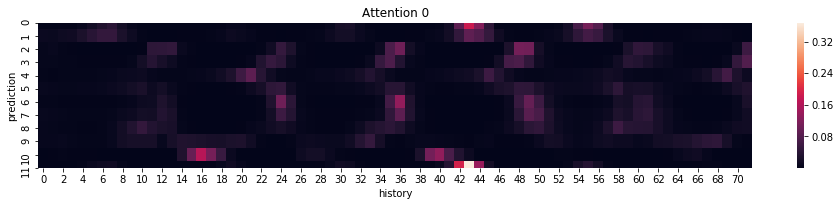

In [16]:
pred_idx = 200
enc_x = torch.tensor(series[pred_idx - enc_lens: pred_idx]).unsqueeze(0).float()
cat_x = torch.tensor(month[pred_idx-enc_lens: pred_idx + dec_lens]).unsqueeze(0).unsqueeze(2).long()
y_pred, attns = model.predict(enc_x, dec_lens, category_x=cat_x, use_move_scale=True, return_attns=True)
plot_attentions(attns)

Text(0.5, 1.0, 'Seq2Seq 1 Attention prediction')

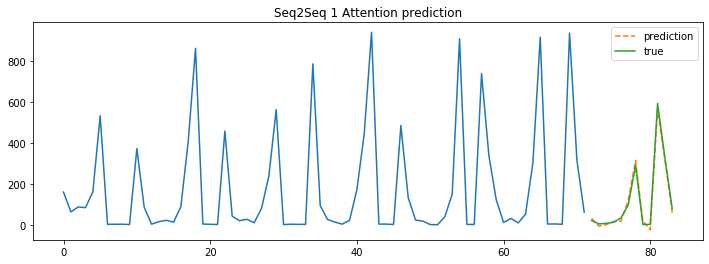

In [17]:
k = 0
h = 0

enc_seqs = val_set[k]['enc_inputs']
enc_inputs = torch.tensor(enc_seqs).unsqueeze(0)
category_x = torch.tensor(val_set[k]['category_x']).unsqueeze(0)
dec_outputs = val_set[k]['dec_outputs']
dec_step = dec_outputs.shape[0]
pred = model.predict(enc_inputs, dec_step, category_x=category_x, use_move_scale=True).squeeze().detach().numpy()
plot_prediction(enc_seqs[:, h], pred[:, h], dec_outputs[:, h])
plt.title('Seq2Seq 1 Attention prediction')

## 4. Seq2Seq(Attention 4)

In [18]:
hp = {
        'path': Path('.').resolve() / 'logs',
        'target_size': 20,
        'rnn_type': 'LSTM',
        'dropout': 0.1,
        'hidden_size': 128,
        'teacher_forcing_rate': 0.5,
        'n_head': 4,
        'use_attn': True,
        'trans_hidden_size': 4,
        'trans_continuous_var': None,
        'trans_category_var': [(13, 2)],
        'trans_bidirectional': True,
        'trans_rnn_type': 'LSTM',
        'use_move_scale': True,
    }

compile_params = {
    'loss_fn': 'MSELoss',
    'optimizer': 'Adam',
    'lr': 0.001,
    'lr_scheduler': 'CosineAnnealingWarmRestarts',
    'lr_scheduler_kw': {'T_0': 5, 'T_mult': 10},
    'metric': 'RMSE',
}

model = Seq2Seq(hp)
model.compile(**compile_params)
model.fit(epochs, trn_ld, val_ld, early_stopping=10, save_every_n_epochs=None, save_best_model=True)

batch 17 / 17, loss 0.727: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.60it/s]


epoch 1 / 100: train loss 0.981 val loss 0.975 RMSE 167.292
create model path: C:\Users\evilp\project\Deep-Time-Series-Prediction\notebooks\logs


batch 17 / 17, loss 1.141: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.74it/s]


epoch 2 / 100: train loss 0.789 val loss 0.864 RMSE 155.440


batch 17 / 17, loss 0.604: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.01it/s]


epoch 3 / 100: train loss 0.690 val loss 0.835 RMSE 152.604


batch 17 / 17, loss 0.681: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.54it/s]


epoch 4 / 100: train loss 0.687 val loss 0.818 RMSE 150.896


batch 17 / 17, loss 0.587: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.78it/s]


epoch 5 / 100: train loss 0.667 val loss 0.819 RMSE 150.949


batch 17 / 17, loss 0.712: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.97it/s]


epoch 6 / 100: train loss 0.659 val loss 0.801 RMSE 148.883


batch 17 / 17, loss 0.485: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.36it/s]


epoch 7 / 100: train loss 0.648 val loss 0.774 RMSE 145.439


batch 17 / 17, loss 0.451: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.61it/s]


epoch 8 / 100: train loss 0.563 val loss 0.746 RMSE 144.506


batch 17 / 17, loss 0.432: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.77it/s]


epoch 9 / 100: train loss 0.560 val loss 0.719 RMSE 141.308


batch 17 / 17, loss 0.496: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.14it/s]


epoch 10 / 100: train loss 0.517 val loss 0.713 RMSE 141.198


batch 17 / 17, loss 0.429: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.42it/s]


epoch 11 / 100: train loss 0.473 val loss 0.679 RMSE 136.345


batch 17 / 17, loss 0.363: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.10it/s]


epoch 12 / 100: train loss 0.450 val loss 0.670 RMSE 135.688


batch 17 / 17, loss 0.388: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.26it/s]


epoch 13 / 100: train loss 0.440 val loss 0.668 RMSE 134.393


batch 17 / 17, loss 0.480: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.07it/s]


epoch 14 / 100: train loss 0.449 val loss 0.619 RMSE 130.024


batch 17 / 17, loss 0.330: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.14it/s]


epoch 15 / 100: train loss 0.401 val loss 0.608 RMSE 126.994


batch 17 / 17, loss 0.430: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.64it/s]


epoch 16 / 100: train loss 0.389 val loss 0.590 RMSE 126.120


batch 17 / 17, loss 0.332: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.41it/s]


epoch 17 / 100: train loss 0.331 val loss 0.552 RMSE 120.872


batch 17 / 17, loss 0.254: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.75it/s]


epoch 18 / 100: train loss 0.338 val loss 0.544 RMSE 119.301


batch 17 / 17, loss 0.292: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.85it/s]


epoch 19 / 100: train loss 0.302 val loss 0.530 RMSE 116.132


batch 17 / 17, loss 0.239: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.86it/s]


epoch 20 / 100: train loss 0.277 val loss 0.492 RMSE 110.778


batch 17 / 17, loss 0.224: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.98it/s]


epoch 21 / 100: train loss 0.252 val loss 0.474 RMSE 106.747


batch 17 / 17, loss 0.227: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.08it/s]


epoch 22 / 100: train loss 0.235 val loss 0.437 RMSE 101.156


batch 17 / 17, loss 0.212: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.90it/s]


epoch 23 / 100: train loss 0.216 val loss 0.424 RMSE 98.318


batch 17 / 17, loss 0.162: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.41it/s]


epoch 24 / 100: train loss 0.190 val loss 0.398 RMSE 93.220


batch 17 / 17, loss 0.149: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.73it/s]


epoch 25 / 100: train loss 0.179 val loss 0.391 RMSE 90.939


batch 17 / 17, loss 0.150: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.83it/s]


epoch 26 / 100: train loss 0.163 val loss 0.378 RMSE 88.174


batch 17 / 17, loss 0.131: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.03it/s]


epoch 27 / 100: train loss 0.155 val loss 0.356 RMSE 85.416


batch 17 / 17, loss 0.133: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.87it/s]


epoch 28 / 100: train loss 0.149 val loss 0.349 RMSE 82.265


batch 17 / 17, loss 0.138: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.62it/s]


epoch 29 / 100: train loss 0.135 val loss 0.343 RMSE 79.794


batch 17 / 17, loss 0.292: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.00it/s]


epoch 30 / 100: train loss 0.134 val loss 0.332 RMSE 78.280


batch 17 / 17, loss 0.109: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.98it/s]


epoch 31 / 100: train loss 0.122 val loss 0.317 RMSE 75.151


batch 17 / 17, loss 0.104: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.54it/s]


epoch 32 / 100: train loss 0.112 val loss 0.304 RMSE 72.932


batch 17 / 17, loss 0.093: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.01it/s]


epoch 33 / 100: train loss 0.108 val loss 0.298 RMSE 70.724


batch 17 / 17, loss 0.100: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.74it/s]


epoch 34 / 100: train loss 0.105 val loss 0.289 RMSE 69.196


batch 17 / 17, loss 0.090: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.86it/s]


epoch 35 / 100: train loss 0.101 val loss 0.288 RMSE 68.680


batch 17 / 17, loss 0.106: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.21it/s]


epoch 36 / 100: train loss 0.097 val loss 0.286 RMSE 67.834


batch 17 / 17, loss 0.087: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.71it/s]


epoch 37 / 100: train loss 0.096 val loss 0.275 RMSE 66.761


batch 17 / 17, loss 0.084: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.16it/s]


epoch 38 / 100: train loss 0.090 val loss 0.267 RMSE 64.998


batch 17 / 17, loss 0.082: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.94it/s]


epoch 39 / 100: train loss 0.088 val loss 0.262 RMSE 64.046


batch 17 / 17, loss 0.076: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.41it/s]


epoch 40 / 100: train loss 0.085 val loss 0.263 RMSE 63.684


batch 17 / 17, loss 0.073: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.89it/s]


epoch 41 / 100: train loss 0.085 val loss 0.261 RMSE 63.248


batch 17 / 17, loss 0.066: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.85it/s]


epoch 42 / 100: train loss 0.082 val loss 0.258 RMSE 62.556


batch 17 / 17, loss 0.085: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.29it/s]


epoch 43 / 100: train loss 0.081 val loss 0.261 RMSE 62.275


batch 17 / 17, loss 0.106: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.43it/s]


epoch 44 / 100: train loss 0.080 val loss 0.261 RMSE 62.024


batch 17 / 17, loss 0.068: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.79it/s]


epoch 45 / 100: train loss 0.080 val loss 0.252 RMSE 61.322


batch 17 / 17, loss 0.060: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.77it/s]


epoch 46 / 100: train loss 0.079 val loss 0.253 RMSE 61.224


batch 17 / 17, loss 0.054: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.66it/s]


epoch 47 / 100: train loss 0.078 val loss 0.252 RMSE 60.871


batch 17 / 17, loss 0.057: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.19it/s]


epoch 48 / 100: train loss 0.075 val loss 0.251 RMSE 60.809


batch 17 / 17, loss 0.068: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.92it/s]


epoch 49 / 100: train loss 0.076 val loss 0.252 RMSE 60.762


batch 17 / 17, loss 0.121: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.78it/s]


epoch 50 / 100: train loss 0.079 val loss 0.251 RMSE 60.653


batch 17 / 17, loss 0.080: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.07it/s]


epoch 51 / 100: train loss 0.076 val loss 0.250 RMSE 60.567


batch 17 / 17, loss 0.069: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.28it/s]


epoch 52 / 100: train loss 0.075 val loss 0.251 RMSE 60.579


batch 17 / 17, loss 0.068: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.10it/s]


epoch 53 / 100: train loss 0.076 val loss 0.251 RMSE 60.544


batch 17 / 17, loss 0.075: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.73it/s]


epoch 54 / 100: train loss 0.077 val loss 0.251 RMSE 60.527


batch 17 / 17, loss 0.071: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.02it/s]


epoch 55 / 100: train loss 0.076 val loss 0.251 RMSE 60.525


batch 17 / 17, loss 0.069: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.00it/s]


epoch 56 / 100: train loss 0.079 val loss 0.256 RMSE 62.977


batch 17 / 17, loss 0.111: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.83it/s]


epoch 57 / 100: train loss 0.085 val loss 0.251 RMSE 65.847


batch 17 / 17, loss 0.119: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.97it/s]


epoch 58 / 100: train loss 0.099 val loss 0.271 RMSE 72.271


batch 17 / 17, loss 0.149: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.70it/s]


epoch 59 / 100: train loss 0.163 val loss 0.333 RMSE 85.430


batch 17 / 17, loss 0.104: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.21it/s]


epoch 60 / 100: train loss 0.161 val loss 0.347 RMSE 83.007


batch 17 / 17, loss 0.101: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.22it/s]


epoch 61 / 100: train loss 0.111 val loss 0.310 RMSE 74.587


batch 17 / 17, loss 0.070: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.72it/s]


epoch 62 / 100: train loss 0.090 val loss 0.262 RMSE 63.748


batch 17 / 17, loss 0.066: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.16it/s]


epoch 63 / 100: train loss 0.070 val loss 0.236 RMSE 54.993


batch 17 / 17, loss 0.047: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.88it/s]


epoch 64 / 100: train loss 0.060 val loss 0.228 RMSE 52.867


batch 17 / 17, loss 0.053: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.11it/s]


epoch 65 / 100: train loss 0.056 val loss 0.227 RMSE 51.212


batch 17 / 17, loss 0.048: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.51it/s]


epoch 66 / 100: train loss 0.054 val loss 0.226 RMSE 50.637


batch 17 / 17, loss 0.047: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.28it/s]


epoch 67 / 100: train loss 0.051 val loss 0.225 RMSE 49.423


batch 17 / 17, loss 0.085: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.83it/s]


epoch 68 / 100: train loss 0.050 val loss 0.220 RMSE 49.129


batch 17 / 17, loss 0.036: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.36it/s]


epoch 69 / 100: train loss 0.046 val loss 0.220 RMSE 48.483


batch 17 / 17, loss 0.046: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.42it/s]


epoch 70 / 100: train loss 0.044 val loss 0.212 RMSE 47.304


batch 17 / 17, loss 0.037: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.92it/s]


epoch 71 / 100: train loss 0.043 val loss 0.216 RMSE 47.639


batch 17 / 17, loss 0.042: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.21it/s]


epoch 72 / 100: train loss 0.042 val loss 0.213 RMSE 46.663


batch 17 / 17, loss 0.035: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.50it/s]


epoch 73 / 100: train loss 0.039 val loss 0.212 RMSE 46.158


batch 17 / 17, loss 0.037: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.41it/s]


epoch 74 / 100: train loss 0.039 val loss 0.210 RMSE 45.833


batch 17 / 17, loss 0.033: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.97it/s]


epoch 75 / 100: train loss 0.039 val loss 0.207 RMSE 45.747


batch 17 / 17, loss 0.026: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.84it/s]


epoch 76 / 100: train loss 0.038 val loss 0.212 RMSE 45.365


batch 17 / 17, loss 0.034: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.72it/s]


epoch 77 / 100: train loss 0.037 val loss 0.205 RMSE 44.506


batch 17 / 17, loss 0.032: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.79it/s]


epoch 78 / 100: train loss 0.037 val loss 0.207 RMSE 44.398


batch 17 / 17, loss 0.036: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.77it/s]


epoch 79 / 100: train loss 0.036 val loss 0.207 RMSE 44.696


batch 17 / 17, loss 0.032: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.71it/s]


epoch 80 / 100: train loss 0.037 val loss 0.207 RMSE 44.268


batch 17 / 17, loss 0.036: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.75it/s]


epoch 81 / 100: train loss 0.035 val loss 0.203 RMSE 43.311


batch 17 / 17, loss 0.039: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.91it/s]


epoch 82 / 100: train loss 0.034 val loss 0.208 RMSE 43.145


batch 17 / 17, loss 0.032: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.45it/s]


epoch 83 / 100: train loss 0.032 val loss 0.202 RMSE 42.558


batch 17 / 17, loss 0.033: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.24it/s]


epoch 84 / 100: train loss 0.032 val loss 0.198 RMSE 42.464


batch 17 / 17, loss 0.033: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.30it/s]


epoch 85 / 100: train loss 0.032 val loss 0.202 RMSE 42.949


batch 17 / 17, loss 0.037: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.11it/s]


epoch 86 / 100: train loss 0.031 val loss 0.210 RMSE 43.006


batch 17 / 17, loss 0.034: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.26it/s]


epoch 87 / 100: train loss 0.030 val loss 0.202 RMSE 42.501


batch 17 / 17, loss 0.030: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.71it/s]


epoch 88 / 100: train loss 0.031 val loss 0.206 RMSE 43.623


batch 17 / 17, loss 0.030: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.33it/s]


epoch 89 / 100: train loss 0.029 val loss 0.196 RMSE 41.654


batch 17 / 17, loss 0.026: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.91it/s]


epoch 90 / 100: train loss 0.028 val loss 0.201 RMSE 41.990


batch 17 / 17, loss 0.026: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.02it/s]


epoch 91 / 100: train loss 0.028 val loss 0.195 RMSE 41.359


batch 17 / 17, loss 0.029: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.42it/s]


epoch 92 / 100: train loss 0.029 val loss 0.201 RMSE 41.294


batch 17 / 17, loss 0.022: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.10it/s]


epoch 93 / 100: train loss 0.027 val loss 0.197 RMSE 40.712


batch 17 / 17, loss 0.026: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.10it/s]


epoch 94 / 100: train loss 0.026 val loss 0.194 RMSE 39.851


batch 17 / 17, loss 0.026: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.78it/s]


epoch 95 / 100: train loss 0.027 val loss 0.192 RMSE 39.945


batch 17 / 17, loss 0.025: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.07it/s]


epoch 96 / 100: train loss 0.025 val loss 0.199 RMSE 40.458


batch 17 / 17, loss 0.026: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.75it/s]


epoch 97 / 100: train loss 0.027 val loss 0.195 RMSE 41.288


batch 17 / 17, loss 0.028: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.03it/s]


epoch 98 / 100: train loss 0.026 val loss 0.197 RMSE 39.919


batch 17 / 17, loss 0.021: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.32it/s]


epoch 99 / 100: train loss 0.024 val loss 0.197 RMSE 40.175


batch 17 / 17, loss 0.022: 100%|███████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.65it/s]


epoch 100 / 100: train loss 0.025 val loss 0.202 RMSE 40.215
best model save in C:\Users\evilp\project\Deep-Time-Series-Prediction\notebooks\logs\Seq2Seq_epoch_95_0.192.pkl


In [19]:
model.reload(model.best_model_path())
print(' - ' * 20)
print(f'train loss: {model.eval_cycle(trn_ld)[0]:.3f}, '
      f'valid loss: {model.eval_cycle(val_ld)[0]:.3f}, '
      f'test loss :{model.eval_cycle(test_ld)[0]:.3f}, '
      f'test RMSE :{model.eval_cycle(test_ld)[1]:.3f}, ')
shutil.rmtree(hp['path'])

 -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 
train loss: 0.011, valid loss: 0.192, test loss :0.326, test RMSE :61.818, 


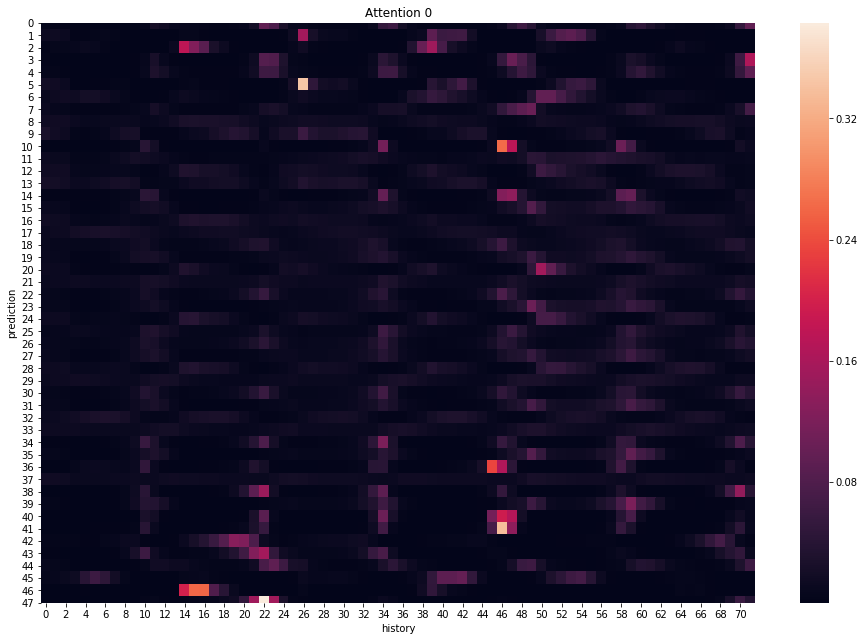

In [20]:
pred_idx = 200
enc_x = torch.tensor(series[pred_idx - enc_lens: pred_idx]).unsqueeze(0).float()
cat_x = torch.tensor(month[pred_idx-enc_lens: pred_idx + dec_lens]).unsqueeze(0).unsqueeze(2).long()
y_pred, attns = model.predict(enc_x, dec_lens, category_x=cat_x, use_move_scale=True, return_attns=True)
plot_attentions(attns)

Text(0.5, 1.0, 'Seq2Seq 4 Attention prediction')

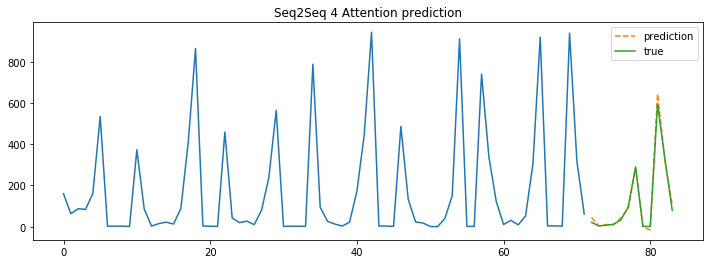

In [21]:
k = 0
h = 0

enc_seqs = val_set[k]['enc_inputs']
enc_inputs = torch.tensor(enc_seqs).unsqueeze(0)
category_x = torch.tensor(val_set[k]['category_x']).unsqueeze(0)
dec_outputs = val_set[k]['dec_outputs']
dec_step = dec_outputs.shape[0]
pred = model.predict(enc_inputs, dec_step, category_x=category_x, use_move_scale=True).squeeze().detach().numpy()
plot_prediction(enc_seqs[:, h], pred[:, h], dec_outputs[:, h])
plt.title('Seq2Seq 4 Attention prediction')

## 5. Simple WaveNet

In [22]:
dataset = SimpleWaveNetDataSet(series, enc_lens, dec_lens)
idxes = list(range(len(dataset)))
train_idxes, _idxes = walk_forward_split(idxes, enc_lens, dec_lens, test_size=n_test + n_val)
valid_idxes, test_idxes = walk_forward_split(_idxes, enc_lens, dec_lens, test_size=n_test)

trn_set = Subset(dataset, train_idxes)
val_set = Subset(dataset, valid_idxes)
test_set = Subset(dataset, test_idxes)
trn_ld = DataLoader(trn_set, batch_size=batch_size, shuffle=True, drop_last=False)
val_ld = DataLoader(val_set, batch_size=batch_size, shuffle=False, drop_last=False)
test_ld = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [23]:
hp = {
        'path': Path('.').resolve() / 'logs',
        'target_size': 20,
        'dilation': [1, 2, 4, 8, 16, 32, 64],
        'dropout': 0.2,
        'residual_channels': 72,
        'teacher_forcing_rate': 0.5,
        'use_move_scale': True,
    }

compile_params = {
    'optimizer': 'Adam',
    'lr': 0.001,
    'lr_scheduler': 'CosineAnnealingWarmRestarts',
    'lr_scheduler_kw': {'T_0': 5, 'T_mult': 10},
    'metric': 'RMSE',
    'loss_fn': 'MSELoss',
}

In [24]:
model = SimpleWaveNet(hp)
model.compile(**compile_params)
model.fit(epochs, trn_ld, val_ld, early_stopping=10, save_every_n_epochs=None, save_best_model=True)

batch 17 / 17, loss 0.907: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.43it/s]


epoch 1 / 100: train loss 1.065 val loss 1.194 RMSE 181.438
create model path: C:\Users\evilp\project\Deep-Time-Series-Prediction\notebooks\logs


batch 17 / 17, loss 0.972: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.41it/s]


epoch 2 / 100: train loss 0.899 val loss 0.961 RMSE 164.567


batch 17 / 17, loss 0.816: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.49it/s]


epoch 3 / 100: train loss 0.788 val loss 0.888 RMSE 157.117


batch 17 / 17, loss 0.692: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.47it/s]


epoch 4 / 100: train loss 0.734 val loss 0.860 RMSE 154.220


batch 17 / 17, loss 0.630: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.53it/s]


epoch 5 / 100: train loss 0.719 val loss 0.859 RMSE 154.093


batch 17 / 17, loss 0.555: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.53it/s]


epoch 6 / 100: train loss 0.678 val loss 0.861 RMSE 155.152


batch 17 / 17, loss 0.530: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.84it/s]


epoch 7 / 100: train loss 0.607 val loss 0.778 RMSE 145.324


batch 17 / 17, loss 0.581: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.58it/s]


epoch 8 / 100: train loss 0.556 val loss 0.758 RMSE 143.632


batch 17 / 17, loss 0.557: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.56it/s]


epoch 9 / 100: train loss 0.507 val loss 0.755 RMSE 144.835


batch 17 / 17, loss 0.366: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.54it/s]


epoch 10 / 100: train loss 0.464 val loss 0.715 RMSE 140.152


batch 17 / 17, loss 0.494: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.35it/s]


epoch 11 / 100: train loss 0.426 val loss 0.680 RMSE 133.671


batch 17 / 17, loss 0.382: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.39it/s]


epoch 12 / 100: train loss 0.398 val loss 0.677 RMSE 133.670


batch 17 / 17, loss 0.371: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.41it/s]


epoch 13 / 100: train loss 0.369 val loss 0.632 RMSE 125.587


batch 17 / 17, loss 0.337: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.43it/s]


epoch 14 / 100: train loss 0.339 val loss 0.568 RMSE 116.700


batch 17 / 17, loss 0.282: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.34it/s]


epoch 15 / 100: train loss 0.319 val loss 0.543 RMSE 114.354


batch 17 / 17, loss 0.289: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.44it/s]


epoch 16 / 100: train loss 0.299 val loss 0.527 RMSE 109.742


batch 17 / 17, loss 0.223: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.41it/s]


epoch 17 / 100: train loss 0.288 val loss 0.507 RMSE 108.689


batch 17 / 17, loss 0.232: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.33it/s]


epoch 18 / 100: train loss 0.269 val loss 0.461 RMSE 100.171


batch 17 / 17, loss 0.251: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.49it/s]


epoch 19 / 100: train loss 0.264 val loss 0.493 RMSE 106.763


batch 17 / 17, loss 0.262: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.46it/s]


epoch 20 / 100: train loss 0.255 val loss 0.436 RMSE 97.295


batch 17 / 17, loss 0.276: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.41it/s]


epoch 21 / 100: train loss 0.239 val loss 0.426 RMSE 96.599


batch 17 / 17, loss 0.223: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.45it/s]


epoch 22 / 100: train loss 0.238 val loss 0.404 RMSE 92.771


batch 17 / 17, loss 0.216: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.27it/s]


epoch 23 / 100: train loss 0.226 val loss 0.395 RMSE 90.533


batch 17 / 17, loss 0.225: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.37it/s]


epoch 24 / 100: train loss 0.225 val loss 0.370 RMSE 89.105


batch 17 / 17, loss 0.240: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.64it/s]


epoch 25 / 100: train loss 0.217 val loss 0.359 RMSE 85.023


batch 17 / 17, loss 0.218: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.53it/s]


epoch 26 / 100: train loss 0.214 val loss 0.367 RMSE 86.592


batch 17 / 17, loss 0.215: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.47it/s]


epoch 27 / 100: train loss 0.206 val loss 0.331 RMSE 81.431


batch 17 / 17, loss 0.181: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.33it/s]


epoch 28 / 100: train loss 0.205 val loss 0.320 RMSE 80.173


batch 17 / 17, loss 0.197: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.44it/s]


epoch 29 / 100: train loss 0.205 val loss 0.312 RMSE 79.473


batch 17 / 17, loss 0.294: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.48it/s]


epoch 30 / 100: train loss 0.200 val loss 0.312 RMSE 79.889


batch 17 / 17, loss 0.196: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.40it/s]


epoch 31 / 100: train loss 0.194 val loss 0.303 RMSE 78.189


batch 17 / 17, loss 0.177: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.57it/s]


epoch 32 / 100: train loss 0.187 val loss 0.289 RMSE 76.095


batch 17 / 17, loss 0.130: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.34it/s]


epoch 33 / 100: train loss 0.189 val loss 0.306 RMSE 77.312


batch 17 / 17, loss 0.161: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.27it/s]


epoch 34 / 100: train loss 0.185 val loss 0.293 RMSE 78.513


batch 17 / 17, loss 0.170: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.33it/s]


epoch 35 / 100: train loss 0.189 val loss 0.262 RMSE 71.139


batch 17 / 17, loss 0.165: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.43it/s]


epoch 36 / 100: train loss 0.180 val loss 0.271 RMSE 72.256


batch 17 / 17, loss 0.219: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.52it/s]


epoch 37 / 100: train loss 0.178 val loss 0.258 RMSE 71.494


batch 17 / 17, loss 0.168: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.44it/s]


epoch 38 / 100: train loss 0.178 val loss 0.269 RMSE 72.130


batch 17 / 17, loss 0.146: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.15it/s]


epoch 39 / 100: train loss 0.179 val loss 0.257 RMSE 70.917


batch 17 / 17, loss 0.179: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.49it/s]


epoch 40 / 100: train loss 0.178 val loss 0.251 RMSE 69.696


batch 17 / 17, loss 0.161: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.38it/s]


epoch 41 / 100: train loss 0.174 val loss 0.249 RMSE 69.896


batch 17 / 17, loss 0.168: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.43it/s]


epoch 42 / 100: train loss 0.176 val loss 0.247 RMSE 68.314


batch 17 / 17, loss 0.172: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.24it/s]


epoch 43 / 100: train loss 0.175 val loss 0.246 RMSE 68.949


batch 17 / 17, loss 0.175: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.41it/s]


epoch 44 / 100: train loss 0.172 val loss 0.235 RMSE 67.100


batch 17 / 17, loss 0.224: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.35it/s]


epoch 45 / 100: train loss 0.179 val loss 0.241 RMSE 67.498


batch 17 / 17, loss 0.203: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.53it/s]


epoch 46 / 100: train loss 0.178 val loss 0.239 RMSE 67.382


batch 17 / 17, loss 0.241: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.34it/s]


epoch 47 / 100: train loss 0.174 val loss 0.242 RMSE 67.934


batch 17 / 17, loss 0.174: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.32it/s]


epoch 48 / 100: train loss 0.170 val loss 0.240 RMSE 68.020


batch 17 / 17, loss 0.162: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.36it/s]


epoch 49 / 100: train loss 0.175 val loss 0.238 RMSE 67.741


batch 17 / 17, loss 0.150: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.24it/s]


epoch 50 / 100: train loss 0.170 val loss 0.240 RMSE 67.919


batch 17 / 17, loss 0.185: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.42it/s]


epoch 51 / 100: train loss 0.173 val loss 0.239 RMSE 67.589


batch 17 / 17, loss 0.178: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.53it/s]


epoch 52 / 100: train loss 0.169 val loss 0.237 RMSE 67.098


batch 17 / 17, loss 0.134: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.32it/s]


epoch 53 / 100: train loss 0.166 val loss 0.236 RMSE 67.017


batch 17 / 17, loss 0.188: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.44it/s]


epoch 54 / 100: train loss 0.176 val loss 0.236 RMSE 67.031


batch 17 / 17, loss 0.183: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.30it/s]


epoch 55 / 100: train loss 0.176 val loss 0.236 RMSE 67.034


batch 17 / 17, loss 0.212: 100%|███████████████████████████████████████████████████████| 17/17 [00:01<00:00, 10.36it/s]


epoch 56 / 100: train loss 0.182 val loss 0.245 RMSE 71.993
early_stopping ! current epochs: 56, best epochs: 44.
model save in C:\Users\evilp\project\Deep-Time-Series-Prediction\notebooks\logs\SimpleWaveNet_epoch_44_0.235.pkl


In [25]:
model.reload(model.best_model_path())
print(' - ' * 20)
print(f'train loss: {model.eval_cycle(trn_ld)[0]:.3f} '
      f'valid loss: {model.eval_cycle(val_ld)[0]:.3f} '
      f'test loss :{model.eval_cycle(test_ld)[0]:.3f} '
      f'test RMSE :{model.eval_cycle(test_ld)[1]:.3f}, ')
shutil.rmtree(hp['path'])

 -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 
train loss: 0.093 valid loss: 0.235 test loss :0.345 test RMSE :81.903, 


In [26]:
val_set[0].keys()

dict_keys(['enc_inputs', 'dec_outputs'])

Text(0.5, 1.0, 'Simple WaveNet prediction')

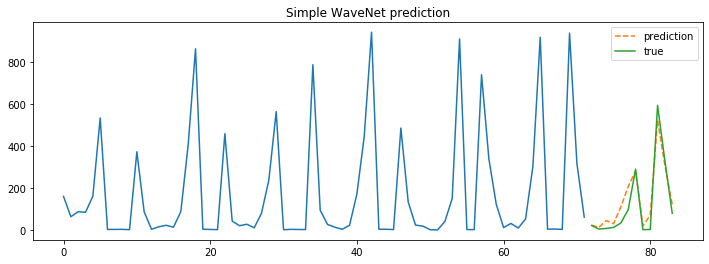

In [27]:
k = 0
h = 0

enc_seqs = val_set[k]['enc_inputs']
enc_inputs = torch.tensor(enc_seqs).unsqueeze(0)
dec_outputs = val_set[k]['dec_outputs']
dec_step = dec_outputs.shape[1]
pred = model.predict(enc_inputs, dec_step, use_move_scale=True).squeeze().detach().numpy()
plot_prediction(enc_seqs[h], pred[h], dec_outputs[h])
plt.title('Simple WaveNet prediction')

## 6. Summary

| model | num of attention | RMSE(test) | loss(test) | loss(val) | loss(train)|
|:-:| :-: | :-:| :-:| :-:| :-:|
| SimpleSeq2Seq | / | 141.54 | 0.725|0.682|0.476|
| Seq2Seq| 0| 120.7| 0.571| 0.491| 0.279|
| Seq2Seq| 1| 113.9| 0.532| 0.427| 0.222|
| Seq2Seq| 4| 67.5 | 0.341| 0.204| 0.028|
| SimpleWaveNet| / | 84.5 | 0.355 | 0.237| 0.093|